# C++ Branch and Bound with Python DefaultUserCallbacks

This implementation shall allow us to quickly implement new ideas an check the performance.
The branch and bound is implemented in reasonably fast C++, while PyBind11 allows us to not only call it but also to add lower and upper bounds via a callback that is called at every node.

In [1]:
# import the stuff
from cetsp.core import Circle, Instance, compute_tour_by_2opt, branch_and_bound, Point, plot_solution

In [3]:
# create a simple instance

import random
circles = [Circle(Point(x*1.5, y*1.5)), 1) for x in range(7) for y in range(7)]
instance = Instance(circles[:20], Point(0,0), Point(10,10))
instance_ = Instance(circles, Point(0,0), Point(10,10))

## Initial Solution

Branch and Bound can benefit from a good upper bound. However, it is also pretty quick in finding good solutions so probably it is more promising to go for lower bounds.

In [4]:
# trigger_lazy_computation an initial solution via 2opt
initial_solution = compute_tour_by_2opt(instance_)

In [5]:
def cb(context):
    if context.current_node.is_feasible():
        traj = context.current_node.get_relaxed_solution()
        for c in circles:
            if not traj.distance(c) <= 0.01:
                print("lazy add c")
                context.add_lazy_circle(c)
        ub = context.get_upper_bound()
        print(f"Found a new solution! The currently best solution has a value of {ub}.")
        
timelimit = 60
opt_solution = branch_and_bound(instance, cb, initial_solution, timelimit)

i	LB	|	UB
0	18.5552	|	55.3879
1	18.9879	|	55.3879
2	19.2576	|	55.3879
3	20.0382	|	55.3879
4	20.0663	|	55.3879
5	20.0663	|	55.3879
6	20.0663	|	55.3879
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
lazy add c
Found a new solution! The currently best solution has a value of 55.38794391663495.
7	20.0663	|	55.3879
8	20.0663	|	55.3879
9	20.0663	|	55.3879
10	20.0663	|	55.3879
20	20.0663	|	55.3879
Found a new solution! The currently best solution has a value of 55.38794391663495.
30	20.0663	|	38.9442
40	20.0663	|	38.9442
50	20.0663	|	38.9442
60	20.0663	|	38.9442
70	20.0663	|	38.9442
80	20.0663	|	38.9442
90	20.0663	|	38.9442
100	20.0663	|	38.9442
200	20.0663	|	38.9442
300	20.0663	|	38.9442
400	20.0663	|	38.9442
500	20.0663	|	38.9442
600	20.0663	|	38.9442
700	20.0663	|	38.9442
800	20.0663	|	3

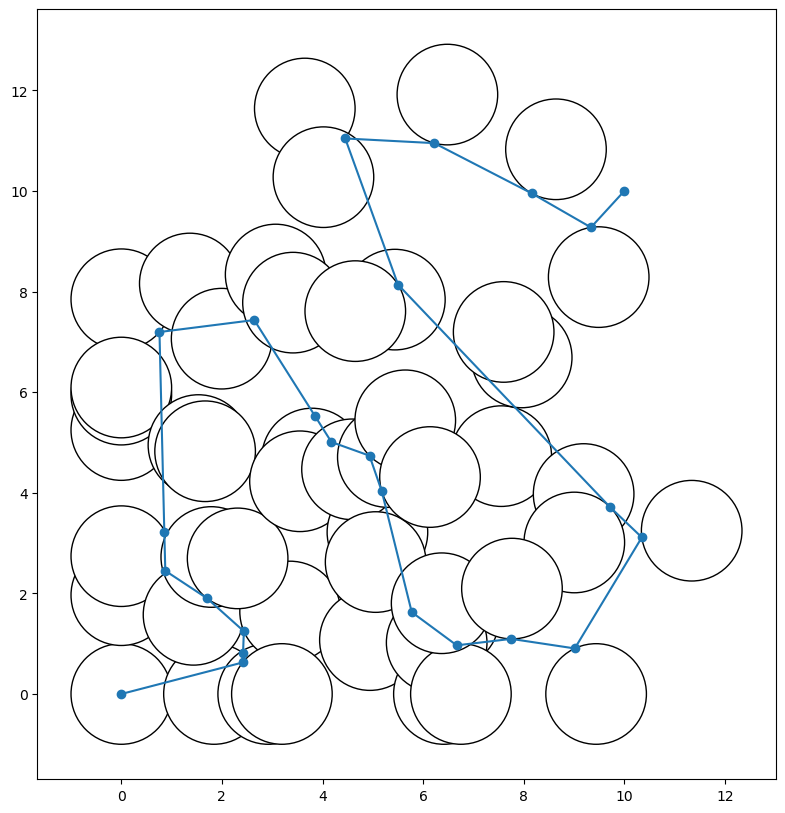

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_solution(plt.gca(), instance_, opt_solution)

## Getting data and manipulating the nodes via callback.

The user_callbacks allow us to access a lot of data and we can use it to influence the BnB in most ways.

The following example does some useless things just to show off. Note how the lower bound gets higher because of this (the lower bound is bad because of the manipulation).

In [6]:
def cb(context):
    order = context.current_node.get_fixed_sequence()
    if len(order)>3 and order[1]<order[2]:  # useless abort if order[1] has a lower index than order[2]
        context.current_node.prune()
        return
    
    if context.current_node.is_feasible():
        ub = context.get_upper_bound()
        obj = context.current_node.get_relaxed_solution().length()
        print(f"Found a new solution of value {obj}! The currently best solution has a value of {ub}.")
        order = context.current_node.get_fixed_sequence()
        print(f"Its sequence is {order}")
    else:
        context.current_node.add_lower_bound(context.current_node.get_lower_bound()*1.05)  # increasing the lb by the relaxation by 5% (also a stupid idea)
        
        
timelimit = 60
opt_solution = branch_and_bound(instance_, cb , initial_solution, timelimit)

i	LB	|	UB
0	26.2151	|	62.3996
1	26.2251	|	62.3996
2	26.2251	|	62.3996
3	26.2251	|	62.3996
4	26.2251	|	62.3996
5	26.2251	|	62.3996
6	26.2251	|	62.3996
7	26.2251	|	62.3996
8	26.2251	|	62.3996
9	26.2251	|	62.3996
10	26.2251	|	62.3996
20	26.2251	|	62.3996
Found a new solution of value 43.41139745384495! The currently best solution has a value of 62.39959822831909.
Its sequence is [35, 45, 37, 43, 44, 32, 39, 17, 30, 15, 8, 1, 2, 3, 12, 4, 33, 20, 41, 26, 47, 34, 40, 48]
30	26.2251	|	43.4114
40	26.2251	|	43.4114
50	26.2251	|	43.4114
Found a new solution of value 43.41139716209627! The currently best solution has a value of 43.41139745384495.
Its sequence is [35, 45, 37, 44, 43, 32, 39, 17, 30, 15, 8, 1, 2, 3, 12, 4, 33, 20, 41, 26, 47, 34, 40, 48]
60	26.2251	|	43.4114
70	26.2251	|	43.4114
80	26.2251	|	43.4114
90	26.2251	|	43.4114
100	26.2251	|	43.4114
200	26.2251	|	43.4114
300	26.2251	|	43.4114
400	26.2251	|	43.4114
500	26.2251	|	43.4114
600	26.2251	|	43.4114
700	26.2251	|	43.4114
Found a n

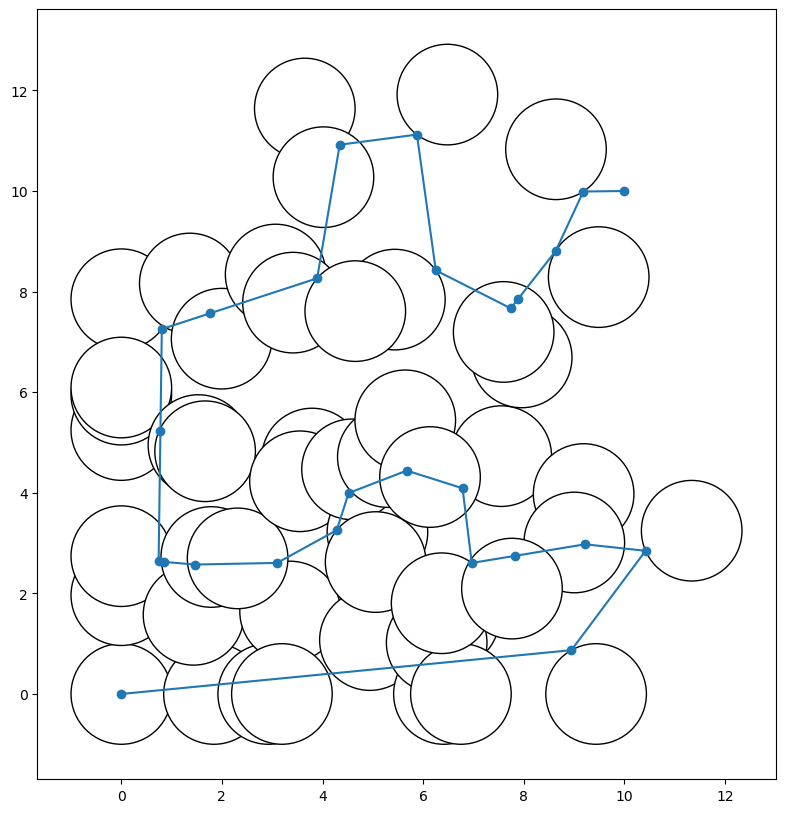

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_solution(plt.gca(), instance_, opt_solution)

In [8]:

def cb(context):
    relaxed_sol = context.get_relaxed_solution()
    for c in circles:
        dist = relaxed_sol.distance(c)
        if dist > 0:
            # this may not really be a lower bound.
            #context.current_node.add_lower_bound(relaxed_sol.length()+dist)
            pass
            
timelimit = 60
opt_solution = branch_and_bound(instance, cb, initial_solution, timelimit)

i	LB	|	UB
0	18.5552	|	55.3879
1	18.9879	|	55.3879
2	19.2576	|	55.3879
3	20.0382	|	55.3879
4	20.0663	|	55.3879
5	20.0663	|	55.3879
6	20.0663	|	55.3879
7	20.0663	|	21.0546
8	20.0663	|	21.0546
9	20.0663	|	21.0546
10	20.0663	|	21.0546
20	20.0663	|	21.0546
30	20.0663	|	21.0546
40	20.4215	|	21.0546
50	20.4215	|	21.0546
60	20.4215	|	21.0546
70	20.4215	|	21.0546
80	20.4215	|	21.0546
90	20.4215	|	21.0546
100	20.4215	|	21.0546
---------------
115	21.0546	|	21.0546
